In [1]:
import os
os.chdir("../")
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import jax.numpy as jnp
import jax
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_probability.substrates.jax as tfp
dist = tfp.distributions
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import time
import numpy as np
jax.config.update("jax_enable_x64", True)

In [3]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib
from matplotlib import pyplot as plt
import GPy

In [4]:
def dataset_load(appliances, train, test=None,split_factor=0.3):
    x_train = []
    y_train = []
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    app = 0
    y_ground = pd.DataFrame()
    #train
    for key, values in train.items():
        for app in range(len(appliances)):
            df = pd.read_csv(f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp","main", appliances[app]])
            df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
            startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
            endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()
            
            if startDate > endDate:
                raise "Start Date must be smaller than Enddate."
            
            df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
            df.dropna(inplace=True)
            if app == 0:
                x = df[appliances[app]].values
                y = jnp.array(df[appliances[app]].values).reshape(-1,1)
            else:
                x += df[appliances[app]].values
                y = jnp.concatenate((y,jnp.array(df[appliances[app]].values).reshape(-1,1)), axis=1)
        # x = df["main"].values
        # y = df[appliances[0]].values
        # x = jnp.pad(x, (units_to_pad, units_to_pad), 'constant', constant_values = (0,0))
        # x = jnp.array([x[i: i + n] for i in range(len(x) - n + 1)])
        x_train.extend(x)
        y_train.extend(y)
    
    # print(x_train.shape)
    x_train = jnp.array(x_train).reshape(-1,1)    
    # print(x_train.shape)
    y_train = jnp.array(y_train).reshape(-1,3)
    # print(y_train.shape)
    x_train = scaler_x.fit_transform(x_train)
    y_train = scaler_y.fit_transform(y_train)

    #test
    x_test = []
    y_test = []
    x_test_timestamp = []
    y_ground = jnp.array([])
    app = 0
    for key, values in test.items():
        for app in range(len(appliances)):
            df = pd.read_csv(f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp","main", appliances[app]])
            df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
            startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
            endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()
            
            if startDate > endDate:
                raise "Start Date must be smaller than Enddate."     
            df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
            df.dropna(inplace=True)
            if app == 0:
                x = df[appliances[app]].values
                y = jnp.array(df[appliances[app]].values).reshape(-1,1)
            else:
                x += df[appliances[app]].values
            # df[appliances[app]].values
                y = jnp.concatenate((y,jnp.array(df[appliances[app]].values).reshape(-1,1)), axis=1)
        # x = df["main"].values
        # y = df[appliances[0]].values
        # x = jnp.pad(x, (units_to_pad, units_to_pad), 'constant', constant_values = (0,0))
        # x = jnp.array([x[i: i + n] for i in range(len(x) - n + 1)])
        # x = df["main"].values
        # y = df[appliances[0]].values
        timestamp = df["Timestamp"].values
        # x = jnp.pad(x, (units_to_pad, units_to_pad), 'constant', constant_values = (0,0))
        # x = jnp.array([x[i: i + n] for i in range(len(x) - n + 1)])
        x_test.extend(x)
        y_test.extend(y)
        x_test_timestamp.extend(timestamp)
    
    # print(y_test.shape)
    x_test = jnp.array(x_test).reshape(-1,1)
    y_test = jnp.array(y_test).reshape(-1,3)
    # print(y_test.shape)
    x_test = scaler_x.transform(x_test)
    x_train = jnp.array(x_train).reshape(x_train.shape[0], 1)
    y_train = jnp.array(y_train).reshape(x_train.shape[0],3)
    x_test = jnp.array(x_test).reshape(x_test.shape[0], 1)
    y_test = jnp.array(y_test).reshape(x_test.shape[0],3)
    # x_train,x_cal , y_train, y_cal = train_test_split(x_train, y_train, test_size=split_factor, random_state=42)
    return x_train, y_train, x_test, y_test, x_test_timestamp, scaler_x, scaler_y

In [5]:
train ={
    
    1:{
        'start_time': "2011-04-28" ,
        'end_time': "2011-05-15"
                },
    3: {
            'start_time': "2011-04-19" ,
            'end_time': "2011-05-22"
        }
                }
test = { 2: {
                'start_time': "2011-04-21" ,
                'end_time': "2011-05-21"
                },
                }

appliances = ["Microwave", "Refrigerator",  "Dish Washer"] #

In [6]:
x_train, y_train, x_test, y_test, x_test_timestamp, scaler_x, scaler_y = dataset_load(appliances, train, test)

In [7]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((24918, 1), (24918, 3), (15656, 1), (15656, 3))

In [8]:
x = x_train[:1000]

In [9]:
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=2.)

In [44]:
def jitter(C,  j = 1e-6):
    return C + np.eye(len(C))*j
    
cov = jitter(kernel.K(x.reshape(-1, 1)))

mvn = multivariate_normal(cov=cov)
cov.shape

(1000, 1000)

(1000,)


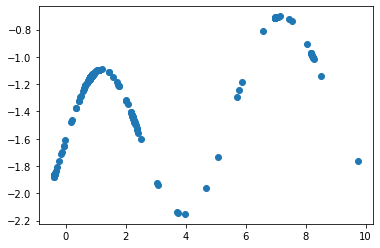

In [89]:
u1 = mvn.rvs(random_state=0)
print(u1.shape)
plt.scatter(x, u1)

In [46]:
def softmax(x):
    return(jnp.exp(x)/jnp.exp(x).sum())

a11 = 0.9
a12 = 0.7
a = np.array([a11, a12]).reshape(-1, 1)
a = softmax(a)
a


DeviceArray([[0.549834],
             [0.450166]], dtype=float64)

In [47]:
B = a@a.T
B, B.shape

(DeviceArray([[0.30231742, 0.24751657],
              [0.24751657, 0.20264943]], dtype=float64),
 (2, 2))

In [48]:
## Kronecker product 
cov_f = np.kron(B, cov)
cov_f.shape

(2000, 2000)

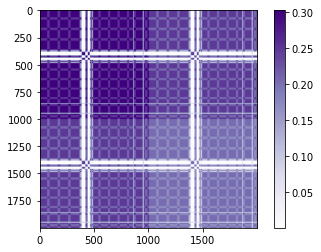

In [49]:
plt.imshow(cov_f, cmap='Purples')
plt.colorbar()

In [125]:
f_sample = multivariate_normal(cov=jitter(cov_f)).rvs(size=1000)
f1_samples, f2_samples = f_sample[:, :1000], f_sample[:, 1000:]

((1000,), (1000, 1000))

In [127]:
f1_samples.shape, f2_samples.shape

((1000, 1000), (1000, 1000))

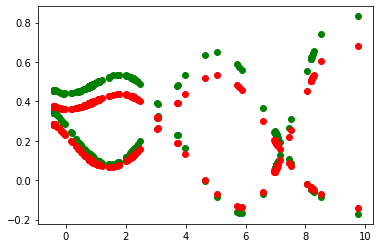

In [92]:
for i in range(2):
    plt.scatter(x, f1_samples[i], color='g') 
    plt.scatter(x, f2_samples[i], color='r' )

(1000,) (1000,)


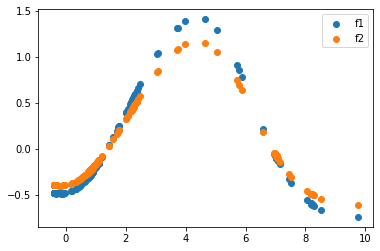

In [93]:
f1_dataset = f1_samples[4]
f2_dataset  = f2_samples[4]

print(f1_dataset.shape, f2_dataset.shape)

plt.scatter(x, f1_dataset, label='f1')
plt.scatter(x, f2_dataset, label='f2')
plt.legend()

In [57]:
import tensorflow_probability.substrates.jax as tfp
from flax import linen as nn

In [58]:
f = jnp.hstack([f1_dataset, f2_dataset])

In [59]:
f.shape

(2000,)

In [60]:
def sqexp(a, b, var=1.0, ls=4):
    diff = (a-b)/ls
    d = jnp.sum(diff ** 2)
    return var*jnp.exp(-0.5 * d)

def all_pairs(f):
    f = jax.vmap(f, in_axes= (None, 0, None, None))
    f = jax. vmap (f, in_axes= (0, None, None, None))
    return f

In [94]:
output_dim = 2
rank = 1
A = jax.random.normal(key=jax.random.PRNGKey(0), shape=(output_dim,rank))
A = softmax(A)
print(A.shape)
A@A.T

(2, 1)


DeviceArray([[0.86298494, 0.06598489],
             [0.06598489, 0.00504529]], dtype=float64)

In [95]:
x_t = x_test[:200]

In [98]:
def covariance_f(var, ls, A):
    """
    A: (output_dim, rank)    
    A can be generated as:
    A = jax.random.normal(key=jax.random.PRNGKey(0), shape=(output_dim,rank))
    """
    A = nn.softmax(A)
    # print(A.shape)
    B = A@A.T
    cov = all_pairs(sqexp)(jnp.array(x), jnp.array(x), var, ls)
    cov_f = jitter(jnp.kron(B, cov))
    # print(cov_f.shape)
    return cov_f

In [99]:
def cost(var, ls, A):
    cov_f = covariance_f(var, ls, A)
    dist = tfp.distributions.MultivariateNormalFullCovariance(loc = jnp.zeros_like(f), covariance_matrix = cov_f)
    return -dist.log_prob(f)

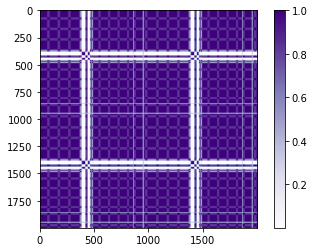

In [100]:
plt.imshow(covariance_f(1.0, 2.0, A), cmap='Purples')
plt.colorbar()

In [101]:
cost(1.0, 2.0, A)

DeviceArray(3076942.3234927, dtype=float64)

In [102]:
grads = jax.grad(cost, argnums=[0, 1, 2])(0.1, 1.0, A)

var = 0.1
ls = 1.0
lr = 1e-3

In [103]:
for i in range(150):
    grads = jax.grad(cost, argnums=[0, 1, 2])(var, ls, A)
    var = var-lr*grads[0]
    ls = ls-lr*grads[1]
    A = A-lr*grads[2]
    if i%100==0:
        print(i, cost(1.0, 1.0, A), var, ls)

0 3076982.3399828942 0.10324509925875464 1.0683838008123712


100 3076982.3399828942 0.23597011070440577 1.9202442586750632


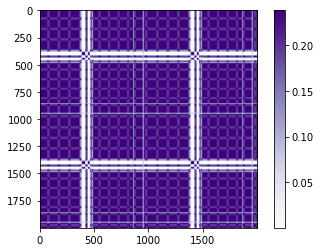

In [104]:
C_learnt = covariance_f(var, ls, A)
plt.imshow(C_learnt, cmap='Purples')
plt.colorbar()

In [105]:
dist = tfp.distributions.MultivariateNormalFullCovariance(covariance_matrix=C_learnt)
samples_f1 = dist.sample(sample_shape=(10, ), seed = jax.random.PRNGKey(0))
samples_f1.shape
# for s in samples_f1:
#     plt.plot(X, s[:50], color='k')
# plt.plot(X, f1_dataset)

(10, 2000)

In [108]:
dist.mean().shape, dist.variance().shape

((2000,), (2000,))

In [116]:
x1 = scaler_x.inverse_transform(x.reshape(-1,1) )
y_pred = scaler_x.inverse_transform(dist.mean()[:1000].reshape(-1,1) )
y =  scaler_y.inverse_transform(y_train)[:1000,0]

In [123]:
x1.max(), x1.min()

(1567.600033, 8.000000000000007)

In [120]:
idx = 400 #x2.shape[0]
start = 0000

plt.figure()
# latexify(width_scale_factor=2, fig_height=1.75)
df = pd.read_csv("./time_stamp.csv", index_col=0)
df.index = df["0"]
df.index = pd.to_datetime(df.index)
df.index.name = "Time"
df = df.drop(columns=["0"])
df["Main Power"] =  x
app = 1
df["Ground Truth"] = y
df["Prediction Dish"] = y_pred
df[start:start+idx].plot(rot=90)
sns.despine()
# df.plot.( rotation=90)
plt.legend(frameon=False, bbox_to_anchor=(0.5, 0.5))
# df.head()
# plt.ylim(0,350)
plt.ylabel("Power")

ValueError: Length of values (1000) does not match length of index (15656)

<Figure size 432x288 with 0 Axes>